<a href="https://colab.research.google.com/github/bingyulab/boolean/blob/main/Boolean_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from deap import base, creator, tools, gp
except ImportError:
    ! pip3 install git+https://github.com/DEAP/deap@master
    !apt-get install -y libtinfo5
    from deap import base, creator, tools, gp

try:
    import pyboolnet.file_exchange as FileExchange
    import pyboolnet.interaction_graphs as IG
    import pyboolnet.attractors as Attractors
    import pyboolnet.state_transition_graphs as STGs
    from pyboolnet.repository import get_primes
    from pyboolnet.file_exchange import bnet2primes
    import pyboolnet.basins_of_attraction as Basins
except ImportError:
    ! pip3 install git+https://github.com/hklarner/pyboolnet@master
    import pyboolnet.file_exchange as FileExchange
    import pyboolnet.interaction_graphs as IG
    import pyboolnet.attractors as Attractors
    import pyboolnet.state_transition_graphs as STGs
    from pyboolnet.repository import get_primes
    from pyboolnet.file_exchange import bnet2primes
    import pyboolnet.basins_of_attraction as Basins

import operator
import random

try:
    import cairosvg
    import igraph as ig
except ImportError:
    !apt-get install graphviz libgraphviz-dev pkg-config
    ! pip3 install pydot igraph cairosvg pygraphviz
    import cairosvg
    import igraph as ig

import matplotlib.pyplot as plt
from PIL import Image
import os

import tempfile
import numpy as np
import matplotlib.image as mpimg

  Cloning https://github.com/DEAP/deap (to revision master) to /tmp/pip-req-build-q9zpr1yg
  Running command git clone --filter=blob:none --quiet https://github.com/DEAP/deap /tmp/pip-req-build-q9zpr1yg
  Resolved https://github.com/DEAP/deap to commit 1509d0b7da639d9d5fbcef361c21af7597480980
  Preparing metadata (setup.py) ... done
  Created wheel for deap: filename=deap-1.4.3-cp311-cp311-linux_x86_64.whl size=133165 sha256=41a423dea197a5cb7fac2fba8e01ac43b2e8c8099d1f05c95bef28a56f40dcd7
  Stored in directory: /tmp/pip-ephem-wheel-cache-ly22bnzc/wheels/9c/aa/68/c99d5e76bdaa7ee29d2cdc93be7e7ae3eb9e4546968286c4a3
Successfully built deap
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libtinfo5
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 100 kB of archives.
After this operation, 557 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubunt

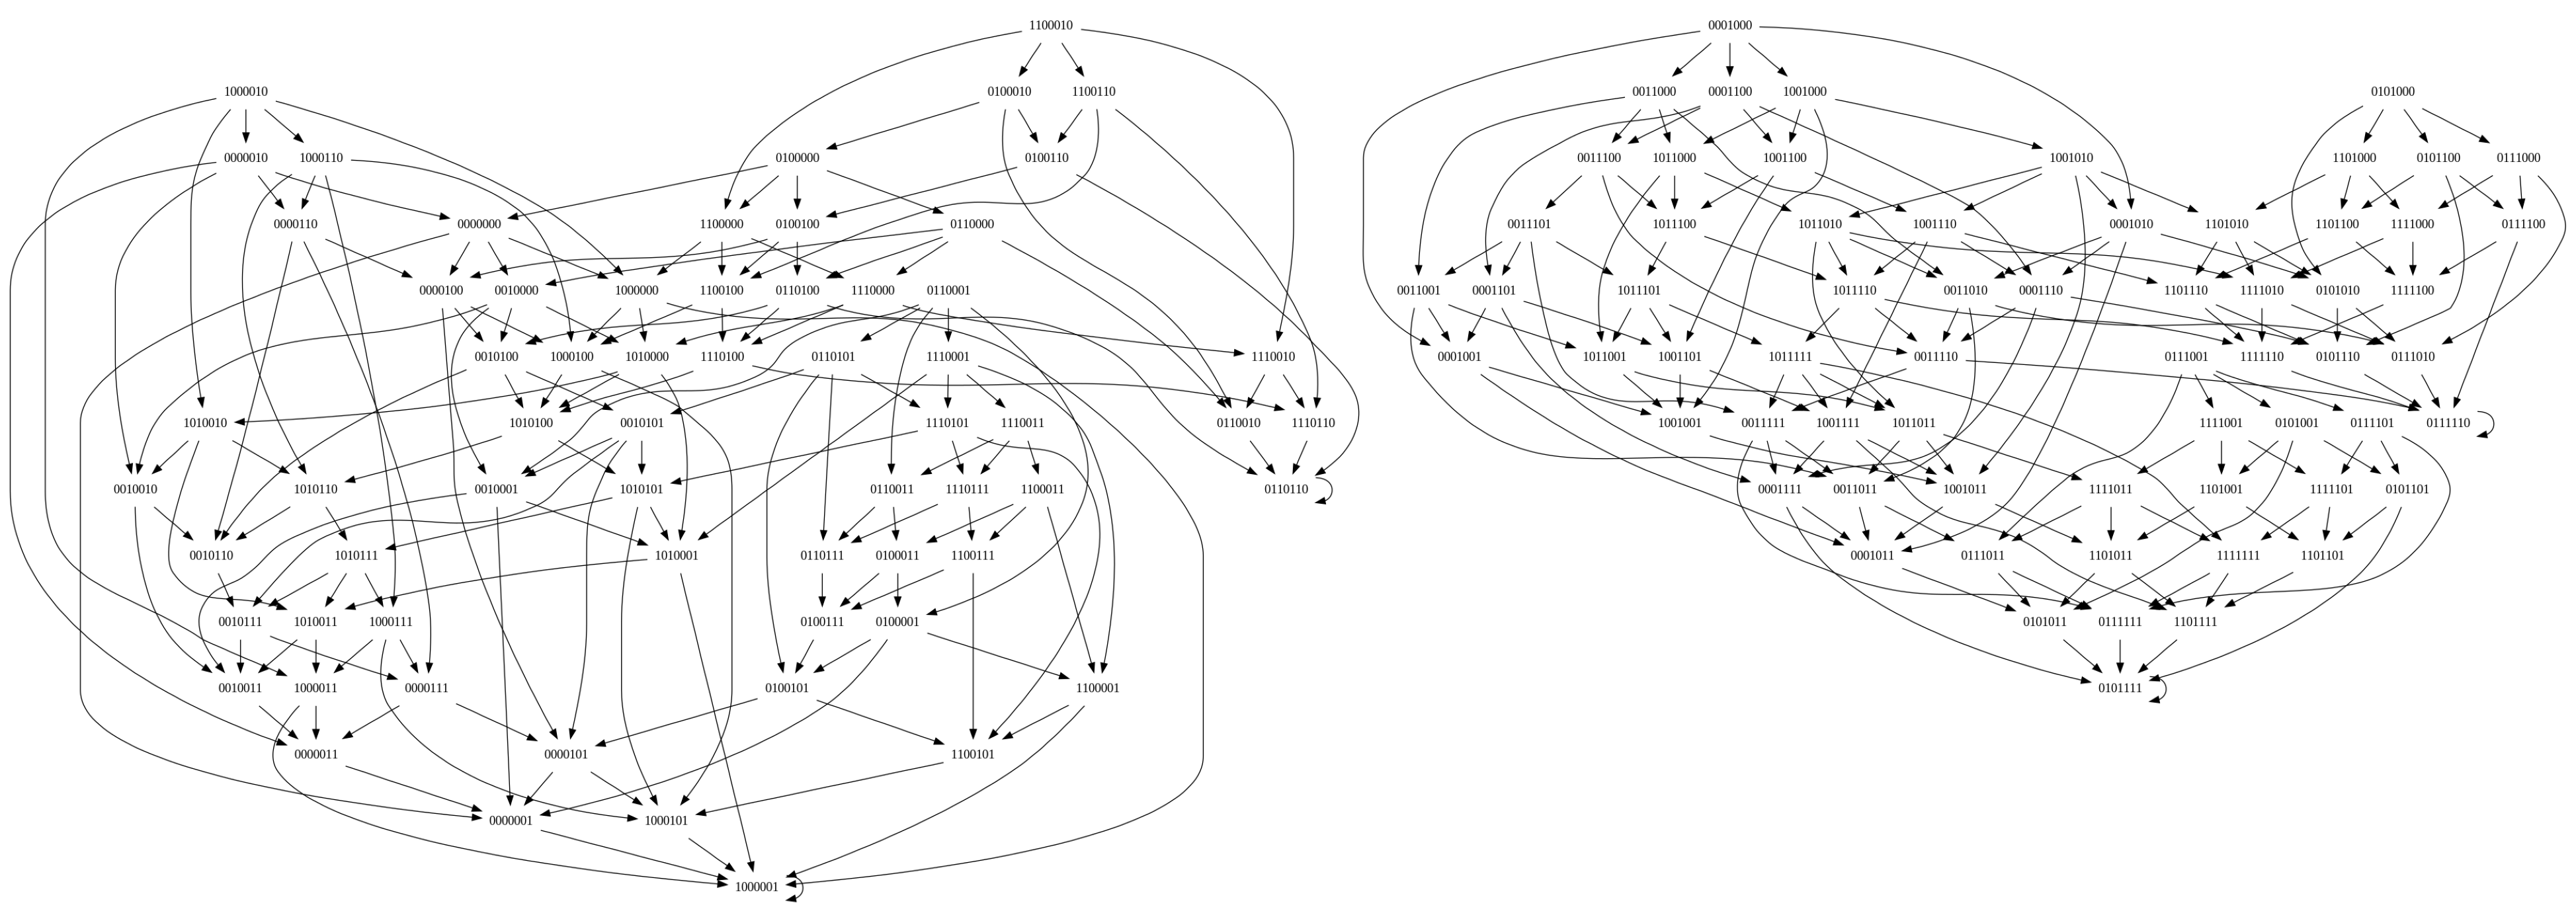

In [2]:
# Load or define a partial Boolean
primes = get_primes("xiao_wnt5a") # faure_cellcycle xiao_wnt5a
STGs.create_stg_image(primes, "asynchronous", "stg_asynchronous.svg")
STGs.create_stg_image(primes, "synchronous",  "stg_synchronous.svg")

def display_pdf_as_image(pdf_path):
    png_path = pdf_path.replace(".svg", ".png")
    cairosvg.svg2png(url=pdf_path, write_to=png_path)
    img = Image.open(png_path)
    plt.figure(figsize=(50, 50))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display both graphs
display_pdf_as_image("stg_asynchronous.svg")

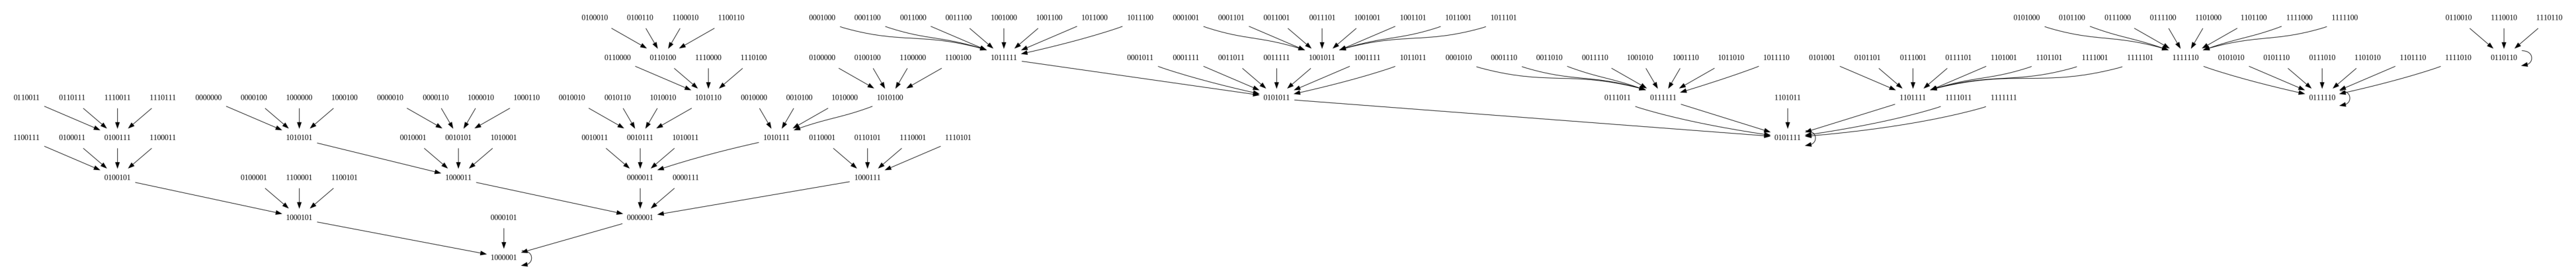

In [3]:
display_pdf_as_image("stg_synchronous.svg")

In [4]:
print("Available nodes:", list(primes.keys()))

Available nodes: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']


In [5]:
def display_svg_file(svg_path):
    """Display an SVG file using matplotlib"""
    if not os.path.exists(svg_path):
        print(f"File {svg_path} does not exist. Skipping visualization.")
        return
    name = svg_path.split('.')[0]
    cairosvg.svg2png(url=f"{name}.svg", write_to=f"{name}.png")
    # Display the PNG image
    img = Image.open(f"{name}.png")
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

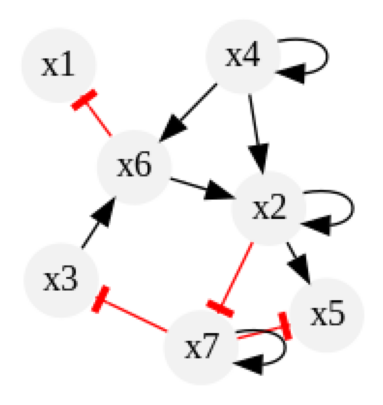

In [6]:
IG.create_image(primes, "igraph.svg")
display_svg_file("igraph.svg")

Think of the Boolean network as a dynamic system where each node (e.g., gene, protein) is either ON (`1`) or OFF (`0`), and their states update over time according to Boolean rules (like `x1 = x2 AND NOT x3`).

As the system evolves step by step, it moves through **states** (combinations of ON/OFF values). Eventually, it will either:

* Fall into a **fixed point** (a state that never changes),
* or enter a **cycle** of repeating states.

These **fixed points or cycles** are called **attractors**.

In [7]:
# Define your desired attractors or behaviors
target_attractors = [
    {"x1":0, "x2":1, "x3":0, "x4":1, "x5":1, "x6":1, "x7":1},  # 0101111
    {"x1":0, "x2":1, "x3":1, "x4":0, "x5":1, "x6":1, "x7":0},  # 0110110
    {"x1":0, "x2":1, "x3":1, "x4":1, "x5":1, "x6":1, "x7":0},  # 0111110
    {"x1":1, "x2":0, "x3":0, "x4":0, "x5":0, "x6":0, "x7":1},  # 1000001
]

# name_map = {"Cdc20":"x1", "CycA":"x2", "CycB":"x3", "CycD":"x4", "CycE":"x5", "E2F":"x6", "Rb":"x7", "UbcH10":"x8", "cdh1":"x9", "p27":"x10"}

# target_attractors = [
#     {"Cdc20":0, "CycA":0, "CycB":0, "CycD":0, "CycE":0, "E2F":0, "Rb":1, "UbcH10":0, "cdh1":1, "p27":1},  # 0000001011
# ]

In [8]:
# Define symbolic functions for GP
def AND(a, b): return a and b
def OR(a, b): return a or b
def NOT(a): return not a

In [9]:
n = len(target_attractors[0])
pset = gp.PrimitiveSetTyped("MAIN", [bool]*n, bool)
pset.addPrimitive(AND, [bool, bool], bool)
pset.addPrimitive(OR, [bool, bool], bool)
pset.addPrimitive(NOT, [bool], bool)
# Add boolean constants for seeding
pset.addEphemeralConstant("CONST0", lambda: False, bool)
pset.addEphemeralConstant("CONST1", lambda: True, bool)
for i in range(n): pset.renameArguments(**{f"ARG{i}": f"x{i+1}"})

/usr/local/lib/python3.11/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral CONST0 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "
/usr/local/lib/python3.11/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral CONST1 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [10]:
# - `FitnessMax`: Defines a fitness class for maximization problems (indicated by positive weights)
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# - `Individual`: Creates a class based on `gp.PrimitiveTree` (which represents programs as trees)
# with a fitness attribute
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

# The toolbox is DEAP's container for all operators used in the evolutionary process:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)

# - `expr`: Creates random tree expressions with depths between 2-6 using the "half and half" method
# The "half and half" method is a popular approach for generating the initial population in genetic programming. It combines two tree generation strategies:
# 1. **Grow method**: Creates trees with varying shapes by randomly selecting nodes from both function and terminal sets at each level, up to a maximum depth. This produces more irregular, potentially shallower trees.
# 2. **Full method**: Creates "full" trees by selecting only function nodes until reaching one level before the maximum depth, then only using terminal nodes at the maximum depth. This creates balanced trees that all reach the maximum depth.
# The "half and half" initialization typically:
# - Creates roughly 50% of the initial population using the grow method
# - Creates roughly 50% using the full method
# This approach ensures good genetic diversity in the initial population by including trees with different structures and shapes, which helps the evolutionary process explore the solution space more effectively.

# Mixed initialization: half full, half grow for diversity
toolbox.register("expr_full", gp.genFull, pset=pset, min_=1, max_=3)
toolbox.register("expr_grow", gp.genGrow, pset=pset, min_=1, max_=3)
def init_ind():
    if random.random() < 0.5:
        return creator.Individual(toolbox.expr_full())
    return creator.Individual(toolbox.expr_grow())
# - `individual`: Creates individuals by wrapping expressions in the `Individual` class
toolbox.register("individual", init_ind)

# - `population`: Creates a list of individuals
toolbox.register("population",   tools.initRepeat, list, toolbox.individual)

# - `mate`: One-point crossover that swaps subtrees between individuals
toolbox.register("mate",   gp.cxOnePoint)
# - `mutate`: Uniform mutation that replaces random subtrees with new ones
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_grow, pset=pset)
# - `select`: Tournament selection with size 3 (selects best individual from 3 random choices)
toolbox.register("select", tools.selTournament, tournsize=3)

# Converts tree representations into executable Python functions that can be evaluated.
toolbox.register("compile", gp.compile, pset=pset)

In [11]:
# --- Convert tree to PyBoolNet formula

def tree_to_pyboolnet_formula(ind, n):
    expr_str = str(ind)
    expr_str = expr_str.replace("AND", "&").replace("OR", "|").replace("NOT", "!")
    expr_str = expr_str.replace("(", " ( ").replace(")", " ) ")
    while "  " in expr_str:
        expr_str = expr_str.replace("  ", " ")
    func = toolbox.compile(expr=ind)
    truth_table = []
    for i in range(2**n):
        bits = format(i, f'0{n}b')
        args = [bit == '1' for bit in bits]
        if func(*args):
            truth_table.append(dict(zip([f"x{j+1}" for j in range(n)], args)))
    if not truth_table: return "0"
    if len(truth_table) == 2**n: return "1"
    terms = []
    for state in truth_table:
        parts = [node if val else f"!{node}" for node, val in state.items()]
        terms.append("(" + " & ".join(parts) + ")")
    return " | ".join(terms)

def tree_to_pyboolnet_formula(ind, n):
    # 0. Ensure it’s a GP tree
    from deap import gp
    if not isinstance(ind, gp.PrimitiveTree):
        raise TypeError("Expecting a DEAP PrimitiveTree, got %r" % type(ind))

    # 1. Compile to a Python function
    func = toolbox.compile(expr=ind)
    # print(f"func: {str(func)}")

    # 2. Evaluate over all 2^n assignments
    vars = [f"x{i+1}" for i in range(n)]
    on_states = []
    for mask in range(2**n):
        vals = [(mask >> i) & 1 == 1 for i in range(n)]
        if func(*vals):
            on_states.append(dict(zip(vars, vals)))

    # 3. Special cases
    if not on_states:
        return "0"
    if len(on_states) == 2**n:
        return "1"

    # 4. Build DNF: conjunctions of literals, OR’ed together
    terms = []
    for st in on_states:
        lits = []
        for v in vars:
            lits.append(v if st[v] else f"!{v}")
        terms.append("(" + " & ".join(lits) + ")")
    return " | ".join(terms)

def update_formula(formula, node_to_evolve):
      # Try the normal PyBoolNet approach
      with tempfile.NamedTemporaryFile(mode='w', suffix='.bnet', delete=False) as f:
          # Copy all original nodes except the one we're evolving
          for node in primes:
              if node != node_to_evolve:
                  # For nodes we're not evolving, use their original rules
                  # This might need adjustment based on how your primes are structured
                  if 'str' in primes[node][1]:
                      original_rule = primes[node][1]['str']
                      f.write(f"{node}, {original_rule}\n")

          # Add our evolved rule
          f.write(f"{node_to_evolve}, {formula}\n")
          temp_file = f.name

      temp_primes = bnet2primes(temp_file)
      # Remove the temporary file
      os.unlink(temp_file)
      return temp_primes

def primes_to_expected_connections(primes):
    """
    Convert PyBoolNet primes to an EXPECTED_CONNECTIONS dictionary.

    Args:
        primes (dict): PyBoolNet primes dictionary representing Boolean rules

    Returns:
        dict: Dictionary mapping each node to a list of its input nodes
    """
    expected_connections = {}

    for node, prime_lists in primes.items():
        # Initialize the list of nodes that influence this node
        expected_connections[node] = []

        # Process positive and negative prime implicants
        for implicant_list in prime_lists:
            for implicant in implicant_list:
                # Get all variables mentioned in this implicant
                for input_node in implicant.keys():
                    if input_node != node and input_node not in expected_connections[node]:
                        expected_connections[node].append(input_node)

    return expected_connections


EXPECTED_CONNECTIONS = primes_to_expected_connections(primes)

In [73]:
# --- Fitness evaluation
def evaluate(individual, node_to_evolve="x1"):
    # print(f'individual:{type(individual)},{individual}')
    n = len(target_attractors[0])
    # Copy the original network
    modified_primes = {k: v.copy() for k, v in primes.items()}
    # print(f"modified_primes: {modified_primes}")

    # Convert the GP tree to a PyBoolNet compatible formula
    formula = tree_to_pyboolnet_formula(individual, n)
    # print(f"formula: {type(formula)}")
    # Directly compile and evaluate the function without NuSMV
    func = toolbox.compile(expr=individual)

    try:
        # Convert BNET to primes format
        temp_primes = update_formula(formula, node_to_evolve)

        # Update only the rule for the specified node
        modified_primes[node_to_evolve] = temp_primes[node_to_evolve]

        # Compute attractors with the modified network
        attractors = Attractors.compute_attractors(modified_primes, "synchronous")
    except Exception as e:
        # Fallback if anything fails
        attractors = Attractors.compute_attractors(primes, "synchronous")


    # Tunable weights
    DYN_WEIGHT             = 1.0   # each attractor match ∈ [0,1], summed
    COVERAGE_WEIGHT        = 2.0   # reduced from 5.0
    CONN_WEIGHT_PER_VAR    = 0.1   # per extra variable beyond 1
    LENGTH_PENALTY_COEF    = 0.2   # stronger penalty for long trees
    OPS_PENALTY_COEF       = 0.1   # stronger penalty on operators
    DISCONNECT_PENALTY     = 50

    # Score the attractors against targets
    total_score = 0.0
    matched = set()
    # 1. Dynamics score: normalized per attractor
    for attractor in attractors.get('attractors', []):
        # print(f"attractor: {attractor}")
        # print(f"individual: {individual}")
        # Extract state from attractor data
        if 'state' in attractor:
            state = attractor['state']
            if isinstance(state, dict):
                attractor_state = state
            elif isinstance(state, str):
                attractor_state = {f"x{i+1}": int(state[i]) for i in range(len(state))}
            else:
                continue

        for t_idx, target in enumerate(target_attractors):
            # best normalized match across all targets
            match_score = sum(1 for k in target if k in attractor_state['dict'] and target[k] == attractor_state['dict'][k])
            normalized_score = match_score / len(target)
            # print(f"match_score: {match_score}, length: {len(target)}, normalized_score:{normalized_score}")

            # Perfect match bonus
            if normalized_score == 1.0:
                # total_score += 10
                matched.add(t_idx)
            else:
                # Partial match points
                total_score += normalized_score * DYN_WEIGHT

    # 2. Coverage bonus: +C per distinct attractor perfectly hit
    coverage_score = len(matched) * COVERAGE_WEIGHT

    # 3. Connectivity bonus: +0.05 per variable used beyond the first
    used_vars = set()
    for i in range(1, n+1):
        if f"x{i}" in str(individual):
            # print(f"x{i}")
            used_vars.add(f"x{i}")

    if len(used_vars) <= 1:
        connectivity_score = - CONN_WEIGHT_PER_VAR * DISCONNECT_PENALTY
    else:
        connectivity_score = CONN_WEIGHT_PER_VAR * len(used_vars)

    connectivity_score = 0
    if len(used_vars) <= 1 or (len(used_vars) == 1 and used_vars[0] == node_to_evolve):
        connectivity_penalty = CONN_WEIGHT_PER_VAR * DISCONNECT_PENALTY  # Increased penalty for self-only rules
    else:
        # Exponential reward for additional nodes
        input_nodes = [n for n in used_vars if n != node_to_evolve]
        connectivity_score = CONN_WEIGHT_PER_VAR * len(used_vars)

        # Bonus for using 3+ nodes
        # if len(used_vars) >= 3:
        #     connectivity_score += 10  # Extra bonus for high connectivity

    # 4. Complexity penalties
    length_penalty = len(individual) * LENGTH_PENALTY_COEF
    ops = (str(individual).count("AND")
          + str(individual).count("OR")
          + str(individual).count("NOT"))
    ops_penalty = (ops ** 1.5) * OPS_PENALTY_COEF

    # 5. topology_bonus = 0
    if node_to_evolve in EXPECTED_CONNECTIONS:
        expected_inputs = EXPECTED_CONNECTIONS[node_to_evolve]

        # Count how many expected connections are present
        correct_connections = sum(1 for node in used_vars
                                  if node in expected_inputs and node != node_to_evolve)

        # Bonus per correct connection
        topology_bonus = correct_connections * 5.0

        # Extra bonus if ALL expected connections are present
        if all(exp in used_vars for exp in expected_inputs if exp != node_to_evolve):
            topology_bonus += 10.0

        # Penalty for unnecessary connections
        unexpected_connections = sum(1 for node in used_vars
                                    if node not in expected_inputs and node != node_to_evolve)
        topology_penalty = unexpected_connections * 2.0

        topology_bonus -= topology_penalty

    # 6. Final fitness
    fitness = total_score + coverage_score + connectivity_score + topology_bonus- length_penalty - ops_penalty
    # if random.random() < 0.05:
    #   print(f"fitness: {fitness:.2f}: = total_score {total_score:.2f} + coverage_score {coverage_score:.2f} + connectivity_score {connectivity_score:.2f} + topology_bonus {topology_bonus} - length_penalty {length_penalty :.2f} - ops_penalty {ops_penalty :.2f}")
    return (max(0.1, fitness),)  # Ensure fitness is at least slightly positive



In [74]:
toolbox.register("evaluate", evaluate)


def run_gp_top1(generations=50, pop_size=100, node_to_evolve="x1"):
    """Run the genetic programming algorithm"""

    # Initialize population
    pop = toolbox.population(n=pop_size)
    # Evaluate initial population
    fitnesses = list(map(lambda ind: evaluate(ind, node_to_evolve), pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    best_fitness = -1
    best_individual = None

    # 5. Evolutionary loop
    for gen in range(1, generations + 1):
        # Adaptive parameters based on generation
        if gen < 10:
            cx_prob, mut_prob = 0.7, 0.3  # Early: high crossover, moderate mutation
            elite_pct = 0.2
        elif gen < 25:
            cx_prob, mut_prob = 0.6, 0.4  # Mid: balanced crossover and mutation
            elite_pct = 0.15
        else:
            cx_prob, mut_prob = 0.5, 0.5  # Late: higher mutation for fine-tuning
            elite_pct = 0.1

        # a) Select the next generation’s parents
        offspring = tools.selTournament(pop, pop_size, tournsize=3)
        offspring = list(map(toolbox.clone, offspring))

        # b) Add elites back in
        elite_count = int(pop_size * elite_pct)
        elites = tools.selBest(pop, elite_count)
        offspring[0:elite_count] = elites

        # c) Variation
        for i in range(0, len(offspring) - 1, 2):
            if random.random() < cx_prob:
                toolbox.mate(offspring[i], offspring[i + 1])
                del offspring[i].fitness.values
                del offspring[i + 1].fitness.values
        for i in range(len(offspring)):
            if random.random() < mut_prob:
                toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        #  d) Evaluate new individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(
            map(lambda ind: evaluate(ind, node_to_evolve), invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # e) Update population, Hall‐of‐Fame, stats
        pop[:] = offspring

        # f) Track best solution
        current_best = tools.selBest(pop, k=1)[0]
        if best_individual is None or current_best.fitness.values[0] > best_fitness:
            best_individual = current_best
            best_fitness = current_best.fitness.values[0]
            # Convert and print the PyBoolNet formula for the current best
            n = len(target_attractors[0])
            formula = tree_to_pyboolnet_formula(best_individual, n)
            print(f"Generation {gen}: Best Fitness = {best_fitness}")
            print(f"PyBoolNet Formula: {formula}\n")
        elif gen % 10 == 0:  # Still print every 10 generations
            print(f"Generation {gen}: Best Fitness = {best_fitness}")
    return tools.selBest(pop, k=1)[0]

node = 'x4'
generations = 15
population_size = 100
# Execute GP and display best solution
print("\nStarting genetic programming to evolve Boolean rules...\n")
best_top1 = run_gp_top1(generations=generations, pop_size=population_size, node_to_evolve=node)  # Reduced for faster testing
formula_top1 = tree_to_pyboolnet_formula(best_top1, len(target_attractors[0]))
print("\nFinal Results:")
print("Best logic expression:", str(best_top1))
print("PyBoolNet formula:", formula_top1)
print("Fitness:", best_top1.fitness.values[0])


Starting genetic programming to evolve Boolean rules...

Generation 1: Best Fitness = 20.64285714285714
PyBoolNet Formula: (!x1 & !x2 & !x3 & x4 & !x5 & x6 & !x7) | (x1 & !x2 & !x3 & x4 & !x5 & x6 & !x7) | (!x1 & x2 & !x3 & x4 & !x5 & x6 & !x7) | (x1 & x2 & !x3 & x4 & !x5 & x6 & !x7) | (!x1 & !x2 & x3 & x4 & !x5 & x6 & !x7) | (x1 & !x2 & x3 & x4 & !x5 & x6 & !x7) | (!x1 & x2 & x3 & x4 & !x5 & x6 & !x7) | (x1 & x2 & x3 & x4 & !x5 & x6 & !x7) | (!x1 & !x2 & !x3 & x4 & x5 & x6 & !x7) | (x1 & !x2 & !x3 & x4 & x5 & x6 & !x7) | (!x1 & x2 & !x3 & x4 & x5 & x6 & !x7) | (x1 & x2 & !x3 & x4 & x5 & x6 & !x7) | (!x1 & !x2 & x3 & x4 & x5 & x6 & !x7) | (x1 & !x2 & x3 & x4 & x5 & x6 & !x7) | (!x1 & x2 & x3 & x4 & x5 & x6 & !x7) | (x1 & x2 & x3 & x4 & x5 & x6 & !x7) | (!x1 & !x2 & !x3 & x4 & !x5 & x6 & x7) | (x1 & !x2 & !x3 & x4 & !x5 & x6 & x7) | (!x1 & x2 & !x3 & x4 & !x5 & x6 & x7) | (x1 & x2 & !x3 & x4 & !x5 & x6 & x7) | (!x1 & !x2 & x3 & x4 & !x5 & x6 & x7) | (x1 & !x2 & x3 & x4 & !x5 & x6 & x7)

In [75]:
def run_gp(generations=50, pop_size=100, node_to_evolve="x1"):
    """Run the genetic programming algorithm"""

    # 1. Initialize population
    pop = toolbox.population(n=pop_size)

    # 2. Set up Hall‐of‐Fame to keep top 5 individuals ever seen
    hof = tools.HallOfFame(5)

    # 3. (Optional) Set up Stats to monitor mean & std dev of fitness
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", lambda fits: sum(fits)/len(fits))
    stats.register("std", lambda fits: (sum((f - sum(fits)/len(fits))**2 for f in fits)/len(fits))**0.5)

    # 4. Evaluate initial population
    invalid = [ind for ind in pop if not ind.fitness.valid]
    for ind in invalid:
        ind.fitness.values = toolbox.evaluate(ind, node_to_evolve)
    hof.update(pop)
    record = stats.compile(pop)
    print(f"Gen 0 – best={hof[0].fitness.values[0]:.3f}, avg={record['avg']:.3f}, std={record['std']:.3f}")

    # 5. Evolutionary loop
    for gen in range(1, generations + 1):
        # Adaptive parameters based on generation
        if gen < 10:
            cx_prob, mut_prob = 0.7, 0.3  # Early: high crossover, moderate mutation
            elite_pct = 0.2
        elif gen < 25:
            cx_prob, mut_prob = 0.6, 0.4  # Mid: balanced crossover and mutation
            elite_pct = 0.15
        else:
            cx_prob, mut_prob = 0.5, 0.5  # Late: higher mutation for fine-tuning
            elite_pct = 0.1

        # a) Select the next generation’s parents
        offspring = tools.selTournament(pop, pop_size, tournsize=3)
        offspring = list(map(toolbox.clone, offspring))

        # b) Add elites back in
        elite_count = int(pop_size * elite_pct)
        elites = tools.selBest(pop, elite_count)
        offspring[0:elite_count] = elites

        # c) Variation
        for i in range(0, len(offspring) - 1, 2):
            if random.random() < cx_prob and i < len(offspring) - 1:
                toolbox.mate(offspring[i], offspring[i + 1])
                del offspring[i].fitness.values
                del offspring[i + 1].fitness.values
        for i in range(len(offspring)):
            if random.random() < mut_prob:
                toolbox.mutate(offspring[i])
                del offspring[i].fitness.values

        #  d) Evaluate new individuals
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(
            map(lambda ind: evaluate(ind, node_to_evolve), invalid_ind))
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # e) Update population, Hall‐of‐Fame, stats
        pop[:] = offspring
        hof.update(pop)
        record = stats.compile(pop)

        # f) Print diagnostics
        if gen % 5 == 0 or gen == generations:
            print(f"Gen {gen:2} – best={hof[0].fitness.values[0]:.3f}, "
                  f"avg={record['avg']:.3f}, std={record['std']:.3f}")

    # 6. Return best ever
    print("\n=== Hall of Fame ===")
    for i, ind in enumerate(hof):
        print(f"{i+1}: Fitness={ind.fitness.values[0]:.3f} Expr={ind}")
    return hof


# Execute GP and display best solution
print("\nStarting genetic programming to evolve Boolean rules...\n")
best_halloffame = run_gp(generations=generations, pop_size=population_size, node_to_evolve=node)  # Reduced for faster testing
formula_halloffame = tree_to_pyboolnet_formula(best_halloffame[0], len(target_attractors[0]))
print("\nFinal Results:")
print("Best logic expression:", str(best_halloffame[0]))
print("PyBoolNet formula:", formula_halloffame)
print("Fitness:", best_halloffame[0].fitness.values[0])


Starting genetic programming to evolve Boolean rules...

Gen 0 – best=22.260, avg=13.623, std=3.176
Gen  5 – best=22.443, avg=19.516, std=3.809
Gen 10 – best=22.443, avg=19.369, std=3.789
Gen 15 – best=22.443, avg=19.572, std=3.772

=== Hall of Fame ===
1: Fitness=22.443 Expr=OR(False, x4)
2: Fitness=22.443 Expr=AND(x4, x4)
3: Fitness=22.443 Expr=OR(x4, False)
4: Fitness=22.443 Expr=AND(True, x4)
5: Fitness=22.443 Expr=OR(x4, x4)

Final Results:
Best logic expression: OR(False, x4)
PyBoolNet formula: (!x1 & !x2 & !x3 & x4 & !x5 & !x6 & !x7) | (x1 & !x2 & !x3 & x4 & !x5 & !x6 & !x7) | (!x1 & x2 & !x3 & x4 & !x5 & !x6 & !x7) | (x1 & x2 & !x3 & x4 & !x5 & !x6 & !x7) | (!x1 & !x2 & x3 & x4 & !x5 & !x6 & !x7) | (x1 & !x2 & x3 & x4 & !x5 & !x6 & !x7) | (!x1 & x2 & x3 & x4 & !x5 & !x6 & !x7) | (x1 & x2 & x3 & x4 & !x5 & !x6 & !x7) | (!x1 & !x2 & !x3 & x4 & x5 & !x6 & !x7) | (x1 & !x2 & !x3 & x4 & x5 & !x6 & !x7) | (!x1 & x2 & !x3 & x4 & x5 & !x6 & !x7) | (x1 & x2 & !x3 & x4 & x5 & !x6 & !x7)

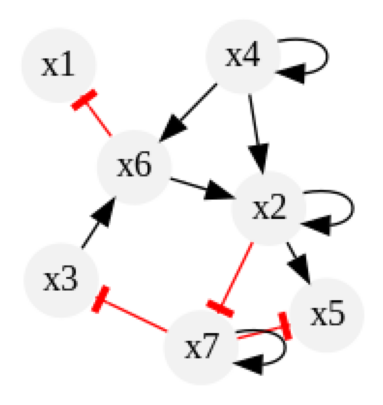

In [79]:
def plot(formula, node_to_evolve, filename):
    # Plot GP network figure (updated network with GP rule for node x1)
    gp_primes = update_formula(formula, node_to_evolve)

    # Create an updated network by replacing the rule for x1
    updated_primes = primes.copy()
    updated_primes[node_to_evolve] = gp_primes[node_to_evolve]

    # Generate and display the interaction graph for the updated network
    IG.create_image(updated_primes, filename)


plot(formula_top1, node, 'igraph_gp_top1.svg')
plot(formula_halloffame, node, 'igraph_gp_halloffame.svg')
display_svg_file("igraph_gp_top1.svg")

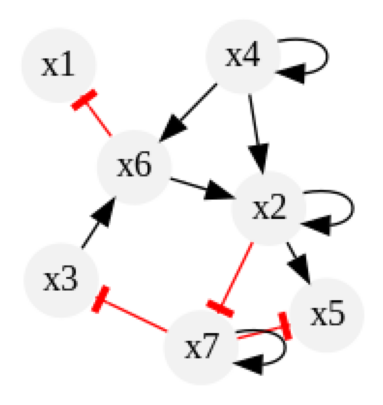

In [80]:
display_svg_file("igraph_gp_halloffame.svg")

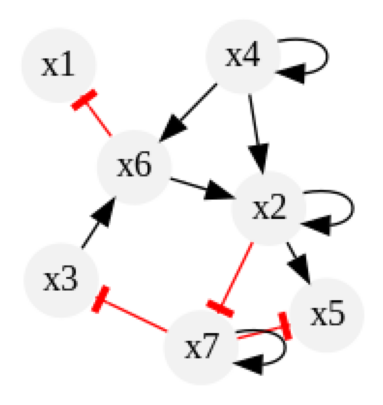

In [86]:
formula_halloffame_extra = tree_to_pyboolnet_formula(best_halloffame[1], len(target_attractors[0]))
plot(formula_halloffame_extra, node, 'igraph_gp_halloffame_extra.svg')
display_svg_file("igraph_gp_halloffame_extra.svg")

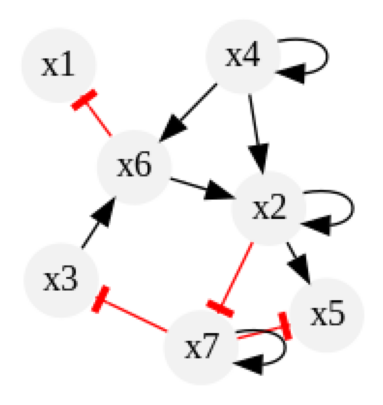

In [38]:
display_svg_file("igraph.svg")

In [45]:
top1_primes = update_formula(formula_top1, node)
halloffame_primes = update_formula(formula_halloffame, node)

print("Original attractors:")
attractors = Attractors.compute_attractors(primes, "synchronous")
print(attractors["is_complete"])
for x in attractors["attractors"]:
    print(x["is_steady"])
    print(x["state"]["str"])

Original attractors:
yes
True
0101111
True
0110110
True
0111110
True
1000001


In [46]:
print("Top 1 attractors:")
attractors = Attractors.compute_attractors(top1_primes, "synchronous")
print(attractors["is_complete"])
for x in attractors["attractors"]:
    print(x["is_steady"])
    print(x["state"]["str"])

Top 1 attractors:
yes
True
0000000
True
0000001
True
0000010
True
0000011
True
0000100
True
0000101
True
0000110
True
0000111
True
0001000
True
0001001
True
0001010
True
0001011
True
0001100
True
0001101
True
0001110
True
0001111
True
0010000
True
0010001
True
0010010
True
0010011
True
0010100
True
0010101
True
0010110
True
0010111
True
0011000
True
0011001
True
0011010
True
0011011
True
0011100
True
0011101
True
0011110
True
0011111
True
0100000
True
0100001
True
0100010
True
0100011
True
0100100
True
0100101
True
0100110
True
0100111
True
0101000
True
0101001
True
0101010
True
0101011
True
0101100
True
0101101
True
0101110
True
0101111
True
0110000
True
0110001
True
0110010
True
0110011
True
0110100
True
0110101
True
0110110
True
0110111
True
0111000
True
0111001
True
0111010
True
0111011
True
0111100
True
0111101
True
0111110
True
0111111
True
1000001
True
1000010
True
1000011
True
1000101
True
1000110
True
1000111
True
1001001
True
1001010
True
1001011
True
1001101
True
1001110
Tru

In [47]:

print("halloffame attractors:")
attractors = Attractors.compute_attractors(halloffame_primes, "synchronous")
print(attractors["is_complete"])
for x in attractors["attractors"]:
    print(x["is_steady"])
    print(x["state"]["str"])

halloffame attractors:
yes
True
0000000
True
0000001
True
0000010
True
0000011
True
0000100
True
0000101
True
0000110
True
0000111
True
0001000
True
0001001
True
0001010
True
0001011
True
0001100
True
0001101
True
0001110
True
0001111
True
0010000
True
0010001
True
0010010
True
0010011
True
0010100
True
0010101
True
0010110
True
0010111
True
0011000
True
0011001
True
0011010
True
0011011
True
0011100
True
0011101
True
0011110
True
0011111
True
0100000
True
0100001
True
0100010
True
0100011
True
0100100
True
0100101
True
0100110
True
0100111
True
0101000
True
0101001
True
0101010
True
0101011
True
0101100
True
0101101
True
0101110
True
0101111
True
0110000
True
0110001
True
0110010
True
0110011
True
0110100
True
0110101
True
0110110
True
0110111
True
0111000
True
0111001
True
0111010
True
0111011
True
0111100
True
0111101
True
0111110
True
0111111
True
1000001
True
1000010
True
1000011
True
1000101
True
1000110
True
1000111
True
1001001
True
1001010
True
1001011
True
1001101
True
100111